# Final use-case : School Failure Prediction

This notebook will try to build a **predictive ai solution** to estimate a school failure for a given student.

The system use a "*Chain of Responsibiliy*" pattern to pipeline the process. Each element of the chain is responsible of one process, then give the result to the other.

This architecture allow to easily change or add process orchestration.

In [110]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from loguru import logger

from pipeline_core.pipeline_core import DataHandler, PipelineContext, PipelineOrchestrator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
from pipeline_core.pipeline_core import PipelineContext


class DataLoader(DataHandler):
    """
    Handle data loading from csv
    """
    def __init__(self, files_to_load, sep=","):
        self.files_to_load = files_to_load
        self.sep = sep

        super().__init__()

    def process(self, context: PipelineContext) -> PipelineContext:
        """
        """
        from file_handling_core.file_manager import FileManager
       

        file_manager = FileManager()

        for name, file in self.files_to_load.items():
            df = file_manager.load_data(file_path=file, sep=self.sep)
            if df is not None and len(df) > 0:
                context.data_map[name] = df

        return context
    

In [112]:
from pipeline_core.pipeline_core import PipelineContext


class SensitiveDataHandler(DataHandler):
    """
    Remove all sensible columns from sources before merge the two dataframes
    See:
        DataHandler abstract class
    """
    def __init__(self, sensitive_columns: list):
        super().__init__()
        self.sensitive_columns = sensitive_columns

    def process(self, context: PipelineContext) -> PipelineContext:
        logger.info(f"🔎 Check sensitives columns in: {len(context.data_map)} sources")

        for name, df in context.data_map.items():
            to_drop = [col for col in self.sensitive_columns if col in df.columns]

            if to_drop:
                context.data_map[name] = df.drop(columns=to_drop)
                logger.debug(f"❌ Remove {to_drop} from source: {name}")
            else:
                logger.debug(f"🌱 No sensitive datas in source: {name}")
        return context

In [113]:
class MergerHandler(DataHandler):
    """
    Merge context dataframe
    Logs process in the context
    """
    def process(self, context: PipelineContext) -> PipelineContext:
        if not context.data_map:
            raise ValueError("❌ MergerHandler : data_map is empty. Nothing to merge")

        source_names = list(context.data_map.keys())
        logger.info(f"🔄 Merge sources : {source_names}")

        # 1. Check for columns consistance
        first_df_cols = set(context.data_map[source_names[0]].columns)
        for name in source_names[1:]:
            current_cols = set(context.data_map[name].columns)
            if first_df_cols != current_cols:
                diff = first_df_cols.symmetric_difference(current_cols)
                logger.warning(f"⚠️ Diffrence between columns was detected {name}: {diff}")
                # Check if we can merge columuns 

        # 2. Prepare and merge
        frames_to_concat = []
        for name, df in context.data_map.items():
            temp_df = df.copy()
            temp_df['source_origin'] = name  # Ajout de la provenance
            frames_to_concat.append(temp_df)

        merged_df = pd.concat(frames_to_concat, ignore_index=True)
        initial_count = len(merged_df)

        # 3. Duplicates handling
        # 'source_origin' ignored to identify real business duplicates
        subset_cols = [col for col in merged_df.columns if col != 'source_origin']
        context.final_df = merged_df.drop_duplicates(subset=subset_cols).reset_index(drop=True)
        
        duplicates_removed = initial_count - len(context.final_df)

        # 4. Store logs in context (dict metadata/logs)
        context.metadata['merger_report'] = {
            'initial_rows': initial_count,
            'final_rows': len(context.final_df),
            'duplicates_removed': duplicates_removed,
            'sources': source_names
        }

        logger.success(f"✅ Merge complete: {len(context.final_df)} rows kept ({duplicates_removed} duplicates remove).")
        
        return context

## Outlier handler

**Sujet** Identifie les valeurs "abérantes" et utlise la stratégie de suppression de la ligne entière

In [114]:
from strategy_core.outliers_strategies import OutlierStrategy

class OutlierHandler(DataHandler):
    def __init__(self, strategy: OutlierStrategy, target_columns: list):
        super().__init__()
        self.strategy = strategy
        self.target_columns = target_columns

    def process(self, context: PipelineContext) -> PipelineContext:
        """
        Identify ludicrous data and remove all row if found
        """
        logger.info("🛠️ Outliers detection running...")
        
        final_df = context.final_df
        if final_df is not None:
            initial_count = len(final_df)
            df_inlier = self.strategy.detect_and_clean(df=final_df, columns=self.target_columns)
            removed = initial_count - len(df_inlier)

            context.final_df = df_inlier

            # Store metadatas
            if "outlier_reports" not in context.metadata:
                context.metadata['outlier_reports'] = {}
            # Get the concrete strategy name
            s_name = self.strategy.__class__.__name__
            context.metadata["outlier_reports"][s_name] = removed

            logger.debug(f"🗑️ {removed} outliers removed using {s_name}.")

        return context

## NaN imputation

**Sujet** : Identifier les valeurs manquantes et utiliser une stratégie pour remplacer

On va utiliser une détection intelligente "regressive" pour isoler les données manquantes et les remplacer.

In [115]:
from sklearn.experimental import enable_iterative_imputer
from pipeline_core.pipeline_core import PipelineContext
from strategy_core.imputation_strategies import ImputationStrategy

class ImputationHandler(DataHandler):
    """
    Identify and impute missing values
    """
    def __init__(self, strategy: ImputationStrategy):
        self.strategy = strategy
        super().__init__()

    def process(self, context: PipelineContext) -> PipelineContext:

        if context.final_df is None:
            logger.error("❌ SmartImputationHandler : final_df is empty. This handler must be place AFTER MergerHandler.")
            return context
        
        df = context.final_df

        # 1. Automatic NaN columns detection
        nan_report = df.isna().sum()
        cols_with_nan = nan_report[nan_report > 0].index.tolist()

        # Only numercial columns are kept
        target_cols = [c for c in cols_with_nan if pd.api.types.is_numeric_dtype(df[c])]

        if not target_cols:
            logger.info("✅ No missing datas detected in the dataframe")
            return context
        

        logger.info("🛠️ Smart NaN imputation running...")

        # Applying strategy
        initial_nan_count = df[target_cols].isna().sum().sum()
        context.final_df = self.strategy.apply(df, target_cols)

        # Logging and metadatas
        context.logs["imputation_report"] = {
            "fixed_columns": target_cols,
            "total_values_filled": int(initial_nan_count)
        }

        logger.success(f"✨ {initial_nan_count} successfuly missing datas processed")
        
        return context

In [116]:
import os
from datetime import datetime
from file_handling_core.file_manager import FileManager

class DataExportHandler(DataHandler):
    """
    Save dataframe using FileHandler
    Comes after cleaning and merging
    """
    def __init__(self, output_dir: str = "outputs/data_processed"):
        super().__init__()
        self.output_dir = output_dir
        self.file_manager = FileManager()
        
        # Create folder if not exists
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
            logger.info(f"📁 Folder created: {self.output_dir}")

    def process(self, context: PipelineContext) -> PipelineContext:
        if context.final_df is None or context.final_df.empty:
            logger.warning("⚠️ DataExportHandler: No data to save (df is empty).")
            return context

        # Filename generation: student_JJMMAAAA_HHMMss_processed.csv
        timestamp = datetime.now().strftime("%d%m%Y_%H%M%S")
        file_name = f"student_{timestamp}_processed.csv"
        full_path = os.path.join(self.output_dir, file_name)

        try:
            logger.info(f"💾 Try to save to {full_path}")
            self.file_manager.save_processed_data(context.final_df, full_path)
            
            # Add log to context
            context.metadata['export_path'] = full_path
            
        except Exception as e:
            logger.error(f"❌ Data export failed: {e}")
            raise # Stop here if failed

        return context

## Learning handler
Using strategies, handler will run Logistic Regression (LR) or Random Forest Classifier (RF) with 4 hypothesis.
During training, MLFlow stores metrics, artifacts and finally store the most powerfull model.

In [117]:
from strategy_core.training_strategies import TrainingStrategy

class ModelHandler(DataHandler):
    def __init__(self, strategy: TrainingStrategy, scenario_label:str):
        """
        Initiate Training Model
        Params:
            strategy: TrainingStrategy one of the strategy to use
            scenario_label: str - Scenario to store into MLFlow tracking
        """
        super().__init__()
        self.strategy = strategy
        self.scenario_label = scenario_label

    def process(self, context: PipelineContext) -> PipelineContext:
        logger.info(f"🚀 Training launching: {self.scenario_label}")
        if context.final_df is None:
            logger.error("❌ dataframe is none. {self.scenario_label} cannot be completed!")
            raise ValueError("Dataframe is none or empty. Training was interrupted")
        
        working_df = context.final_df.copy()

        try:
            self.strategy.execute(working_df, self.scenario_label)
            context.logs[f"model_{self.scenario_label}"] = "Success"
            
        except Exception as e:
            logger.error(f"❌ Training failed for {self.scenario_label}: {e}")
            context.logs[f"model_{self.scenario_label}"] = f"Failed: {e}"
            raise  # Re-raise the exception after logging
        
        return context

## Move logic to yaml configuration

Using configuration, we offer the possibility to handle steps dynamically. The following class read configuration and build the orchestration.

In [118]:
import yaml
import importlib
from loguru import logger

class PipelineBuilder:
    @staticmethod
    def build_from_yaml(config_path: str, orchestrator):
        with open(config_path, 'r', encoding='utf-8') as f:
            config = yaml.safe_load(f)

        logger.info(f"🏗️ Building pipeline from Notebook classes...")

        # 1. Data processing steps
        for step_cfg in config['pipeline']['data_processing']:
            handler_name = step_cfg['step']
            params = step_cfg.get('params', {})
            
            handler = PipelineBuilder._instantiate_notebook_handler(handler_name, step_cfg, params)
            if handler:
                orchestrator.add_handler(handler)

        # 2. Learning steps
        learning_cfg = config['pipeline'].get('learning', {})
        strategies = learning_cfg.get('strategies', [])
        scenarii = learning_cfg.get('scenarii', [])

        for scenario in scenarii:
            for strat_name in strategies:
                # Looking for strategy in the Notebook or imported files
                strategy = PipelineBuilder._get_class_from_anywhere(
                    strat_name, 
                    "strategy_core.training_strategies"
                )(scenario_id=scenario['label'], exclusions=scenario['exclusions'])
                
                # ModelHandler is supposed to be defined in the Notebook or pipeline_core
                ModelHandlerClass = PipelineBuilder._get_class_from_anywhere("ModelHandler")
                handler = ModelHandlerClass(strategy=strategy, scenario_label=scenario['label'])
                orchestrator.add_handler(handler)

        logger.success("✅ Pipeline dynamically orchestrated from the Notebook.")
        return orchestrator

    @staticmethod
    def _get_class_from_anywhere(class_name, module_path=None):
        """Look for a class in the Notebook (globals) or in a specific module"""
        # 1. Look in the classes defined in the Notebook
        if class_name in globals():
            return globals()[class_name]
        
        # 2. If not found and a module path is provided, import the .py file
        if module_path:
            module = importlib.import_module(module_path)
            return getattr(module, class_name)
        
        raise AttributeError(f"❌ Class '{class_name}' is not found in the Notebook or the module.")

    @staticmethod
    def _instantiate_notebook_handler(name, config, params):
        """Specific instantiation for Notebook Handlers"""

        # Special cases of Handlers requiring an internal strategy
        if name == "OutlierHandler":
            target_cols = params.get('target_columns', [])
            strategy_params = {k: v for k, v in params.items() if k != 'target_columns'}
            StrategyClass = PipelineBuilder._get_class_from_anywhere(
                config['strategy'], 
                "strategy_core.outliers_strategies"
            )
            strat = StrategyClass(**strategy_params)
            HandlerClass = PipelineBuilder._get_class_from_anywhere("OutlierHandler")
            return HandlerClass(strategy=strat, target_columns=target_cols)
        
        if name == "ImputationHandler":
            StrategyClass = PipelineBuilder._get_class_from_anywhere(
                config['strategy'], 
                "strategy_core.imputation_strategies"
            )
            strat = StrategyClass(**params)
            HandlerClass = PipelineBuilder._get_class_from_anywhere("ImputationHandler")
            return HandlerClass(strategy=strat)

        # General case: retrieve the class from the Notebook and instantiate it
        HandlerClass = PipelineBuilder._get_class_from_anywhere(name)
        return HandlerClass(**params)

## Orchestrator settings (@Deprecated)
- Sets sources,
- Sets sensitive datas,
- Initiate orchestrator

**Deprecated** after delegating to PiplelineBuilder, there's no need to manually configure the orchestrator

In [119]:
from strategy_core.outliers_strategies import IsolationForestStrategy
from strategy_core.imputation_strategies import AIImputationStrategy

files_to_load = {
    "maths": "datas/student-mat.csv",
    "por": "datas/student-por.csv"
}

sensitives = [
    "romantic", # No correlation
    "Dalc", # Discriminant data, cannot be used
    "Walc", # Discrimant data, cannot be used
]

# Make chain instances :
# 1. Data processing chain
loader = DataLoader(files_to_load=files_to_load)
cleaner = SensitiveDataHandler(sensitive_columns=sensitives)
merger = MergerHandler()

# Sets one of the Outliers detection strategy (Isolation Forest)
outlier_strategy = IsolationForestStrategy(contamination=0.01)
outlier = OutlierHandler(strategy=outlier_strategy, target_columns=["studytime", "absences", "age"])

# Sets one of the Imputation Strategy
imputer_strategy = AIImputationStrategy()
imputer = ImputationHandler(imputer_strategy)

exporter = DataExportHandler()

# Instanciate Pipeline
pipeline = (PipelineOrchestrator()
    .add_handler(loader)
    .add_handler(cleaner)
    .add_handler(merger)
    .add_handler(outlier)
    .add_handler(imputer)
    .add_handler(exporter)
)

# 2. Learning processing
scenarii = [
    (1, "Full_Features", []),
    (2, "No_Sensitive", ["romantic", "Dalc", "Walc"]),
    (3, "No_Sensitive_No_G2", ["romantic", "Dalc", "Walc", "G2"]),
    (4, "No_Sensitive_No_G1_G2", ["romantic", "Dalc", "Walc", "G1", "G2"])
]
from strategy_core.training_strategies import LogisticRegressionStrategy
from strategy_core.training_strategies import RandomForestStrategy
# 2.1 From definitions add strategies needed
for s_id, s_name, s_exclusions in scenarii:
    for strategy_class in [LogisticRegressionStrategy, RandomForestStrategy]:
        strategy = strategy_class(scenario_id=s_name, exclusions=s_exclusions)
        model_handler = ModelHandler(strategy=strategy, scenario_label=s_name)
        pipeline.add_handler(model_handler)


## Run orchestrator

Orchestrator is a Chain of Responsibilies. At the end of the chain, all processes are done.

**Major update** : delegate chain assembly in a configuration file (see : pipeline_config.yml)


2025-12-23 08:47:00.362 | INFO     | __main__:build_from_yaml:11 - 🏗️ Building pipeline from Notebook classes...
2025-12-23 08:47:00.362 | SUCCESS  | __main__:build_from_yaml:40 - ✅ Pipeline dynamically orchestrated from the Notebook.
2025-12-23 08:47:00.363 | INFO     | pipeline_core.pipeline_core:handle:21 - Step DataLoader started...
2025-12-23 08:47:00.366 | INFO     | file_handling_core.file_manager:load_data:13 - 📄 Successfuly loaded data from: datas/student-mat.csv
2025-12-23 08:47:00.369 | INFO     | file_handling_core.file_manager:load_data:13 - 📄 Successfuly loaded data from: datas/student-por.csv
2025-12-23 08:47:00.369 | INFO     | pipeline_core.pipeline_core:handle:21 - Step SensitiveDataHandler started...
2025-12-23 08:47:00.370 | INFO     | __main__:process:15 - 🔎 Check sensitives columns in: 2 sources
2025-12-23 08:47:00.371 | DEBUG    | __main__:process:22 - ❌ Remove ['romantic', 'Dalc', 'Walc'] from source: maths
2025-12-23 08:47:00.371 | DEBUG    | __main__:process:2


Data shape: (395, 33)

Columns: Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

CRows: 395

Types:
 school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           

2025-12-23 08:47:02.315 | INFO     | strategy_core.training_strategies:execute:27 - 🏆 Scenario Full_Features (LR) done.
2025-12-23 08:47:02.318 | INFO     | pipeline_core.pipeline_core:handle:21 - Step ModelHandler started...
2025-12-23 08:47:02.319 | INFO     | __main__:process:16 - 🚀 Training launching: Full_Features
2025-12-23 08:47:02.320 | INFO     | strategy_core.training_strategies:execute:3 - 🚀 Scenario Full_Features (RF) running...
2025/12/23 08:47:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025-12-23 08:47:03.748 | INFO     | pipeline_core.pipeline_core:handle:21 - Step ModelHandler started...
2025-12-23 08:47:03.749 | INFO     | __main__:process:16 - 🚀 Training launching: No_Sensitive
2025-12-23 08:47:03.750 | INFO     | strategy_core.training_strategies:execute:3 - 🚀 Scenario No_Sensitive (LR) running...
2025/12/23 08:47:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025-12-23 08:47:0

🏁 Pipeline execution ended.

--- Merged datas overview ---


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,famrel,freetime,goout,health,absences,G1,G2,G3,source_origin
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,4,3,4,3,6,5,6,6,maths
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,5,3,3,3,4,5,5,6,maths
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,4,3,2,3,10,7,8,10,maths
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,3,2,2,5,2,15,14,15,maths
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,4,3,2,5,4,6,10,10,maths



--- Execution stats ---
DataLoader                : 0.0063s
SensitiveDataHandler      : 0.0024s
MergerHandler             : 0.0045s
OutlierHandler            : 0.0592s
ImputationHandler         : 0.0017s
DataExportHandler         : 0.0058s
ModelHandler              : 1.4400s


<Figure size 800x600 with 0 Axes>

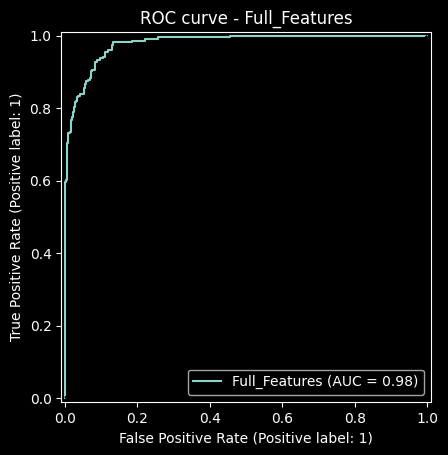

<Figure size 800x600 with 0 Axes>

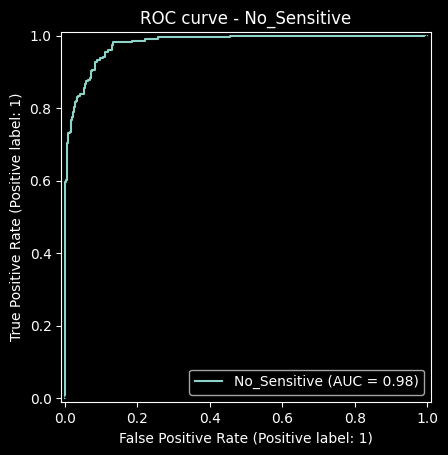

<Figure size 800x600 with 0 Axes>

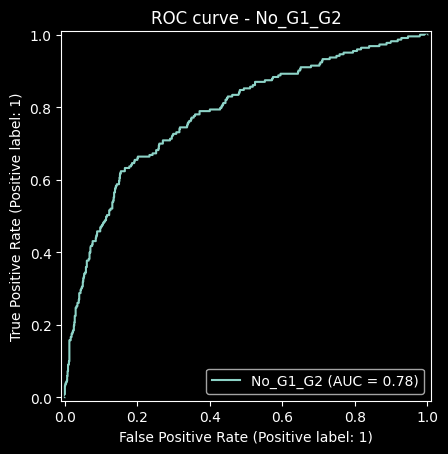

In [120]:
# Initialize context and orchestrator
orchestrator = PipelineOrchestrator()
context = PipelineContext()

# Build pipeline from Notebook classes and YAML config
pipeline = PipelineBuilder.build_from_yaml("pipeline_config.yaml", orchestrator)

# Run the pipeline
try:
    final_context = orchestrator.run(context)
except Exception as e:
    logger.error(f"❌ Pipeline failed: {e}")
finally:
    print("🏁 Pipeline execution ended.")
    
    # Final report
    print("\n--- Merged datas overview ---")
    display(final_context.final_df.head())

    print("\n--- Execution stats ---")
    for step, duration in final_context.execution_time.items():
        print(f"{step:25} : {duration:.4f}s")



## Store the best run

Prepare API exporting the best model (based uppon AUC)

In [ ]:
import joblib
import mlflow

# Get the best model from MLFlow tracking
runs = mlflow.search_runs(order_by=["metrics.auc_score DESC"])
best_run_id = runs.iloc[0]['run_id']

# Load and save the best model locally
best_model = mlflow.sklearn.load_model(model_uri=f"runs:/{best_run_id}/model")
joblib.dump(best_model, "backend/models/student_model_latest.joblib")
print(f"✅ Best model was saved successfully : {runs.iloc[0]['tags.mlflow.runName']}")